In [10]:
from ThesisPackage.Environments.multi_pong_language import PongEnv
from ThesisPackage.Environments.multi_pong_sender_receiver import PongEnvSenderReceiver
from ThesisPackage.RL.Seperated_PPO.multi_ppo import PPO_Separate_Multi_Agent
import torch
import numpy as np
import time
import os

In [11]:
def run_experiment(agents, env, vocab_size, sequence_length, render=False, epochs=50):
    lengths = []
    tokens = {agent: {i: {j:0 for j in range(vocab_size)} for i in range(sequence_length)} for agent in agents.keys()}
    for i in range(100):
        obs, info = env.reset()
        obs = {agent: torch.Tensor(obs[agent]) for agent in env.agents}
        done = {agent: False for agent in env.agents}
        while not any(done.values()):
            actions = {}
            for agent in env.agents:
                action, logprob, _, value = agents[agent].get_action_and_value(obs[agent].unsqueeze(0))
                action = action.cpu().numpy()
                utterances = action[0][1:]
                for i, utterance in enumerate(utterances):
                    tokens[agent][i][utterance] += 1
                actions[agent] = action[0]
            if render:
                try:
                    env.render()
                    time.sleep(0.02)
                except IndexError:
                    pass

            obs, rewards, terminated, truncated, info = env.step(actions)
            obs = {agent: torch.Tensor(obs[agent]) for agent in env.agents}
            terminated = {agent: terminated[agent] for agent in env.agents}
            truncated = {agent: truncated[agent] for agent in env.agents}
            if any(truncated.values()) or any(terminated.values()):
                lengths.append(env.timestep)
                done = {agent: True for agent in env.agents}
                break
    return lengths, tokens

In [12]:
def make_env(seed, vocab_size, sequence_length, max_episode_steps):
    env = PongEnv(width=20, height=20, vocab_size=vocab_size, sequence_length=sequence_length, max_episode_steps=max_episode_steps)
    return env

def make_env_sender_receiver(seed, vocab_size, sequence_length, max_episode_steps, receiver="paddle_2", mute="zero"):
    env = PongEnvSenderReceiver(width=20, height=20, vocab_size=vocab_size, sequence_length=sequence_length, max_episode_steps=max_episode_steps, self_play=True, receiver=receiver, mute_method=mute)
    return env

In [13]:
sequence_length = 2
vocab_size = 3

In [14]:
results = []

In [15]:
env = [make_env(1, vocab_size, sequence_length, 2048)]

agent = PPO_Separate_Multi_Agent(env)
agent.load("/Users/cowolff/Documents/GitHub/ma.pong_rl/models/seperate_network.zip")

/Users/cowolff/miniconda3/envs/thesis/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float16
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [20]:
results_dict = {"default": None, "paddle_1":{}, "paddle_2":{}}

In [21]:
env = make_env(1, vocab_size, sequence_length, 2048)
lengths, tokens = run_experiment(agent.agents, env, vocab_size, sequence_length)
results_dict["default"] = np.mean(lengths)
print(np.mean(lengths))

1680.86


In [22]:
env = make_env_sender_receiver(1, vocab_size, sequence_length, 2048)
lengths, tokens = run_experiment(agent.agents, env, vocab_size, sequence_length)
results_dict["paddle_1"]["zero"] = np.mean(lengths)
print(np.mean(lengths))

874.49


In [23]:
env = make_env_sender_receiver(1, vocab_size, sequence_length, 2048, mute="random")
lengths, tokens = run_experiment(agent.agents, env, vocab_size, sequence_length)
results_dict["paddle_1"]["random"] = np.mean(lengths)
print(np.mean(lengths))

796.98


In [24]:
env = make_env_sender_receiver(1, vocab_size, sequence_length, 2048, receiver="paddle_1", mute="zero")
lengths, tokens = run_experiment(agent.agents, env, vocab_size, sequence_length)
results_dict["paddle_2"]["zero"] = np.mean(lengths)
print(np.mean(lengths))

695.5


In [25]:
env = make_env_sender_receiver(1, vocab_size, sequence_length, 2048, receiver="paddle_1", mute="random")
lengths, tokens = run_experiment(agent.agents, env, vocab_size, sequence_length)
results_dict["paddle_2"]["random"] = np.mean(lengths)
print(np.mean(lengths))

835.43


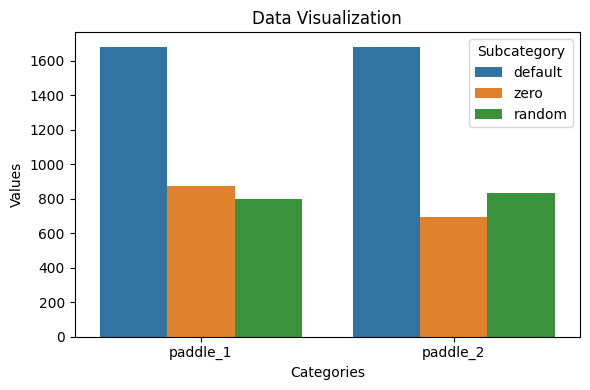

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Transforming the dictionary into a list of tuples for easier DataFrame creation
data_list = []
for key, subdict in results_dict.items():
    if isinstance(subdict, dict):
        data_list.append((key, 'default', results_dict['default']))
        for subkey, value in subdict.items():
            data_list.append((key, subkey, value))

# Creating the DataFrame
df = pd.DataFrame(data_list, columns=['Category', 'Subcategory', 'Value'])

# Plotting
plt.figure(figsize=(6, 4))
sns.barplot(x='Category', y='Value', hue='Subcategory', data=df)
plt.title('Data Visualization')
plt.ylabel('Values')
plt.xlabel('Categories')
plt.legend(title='Subcategory')
plt.tight_layout()
plt.show()